In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c
from scipy.signal import fftconvolve
from scipy.signal.windows import hamming, blackman, kaiser
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import csv
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv, gen_nlfm_to_csv
pulse_width = 5000
pulse_separation = 0
B = 12e6

# Pulse Integration

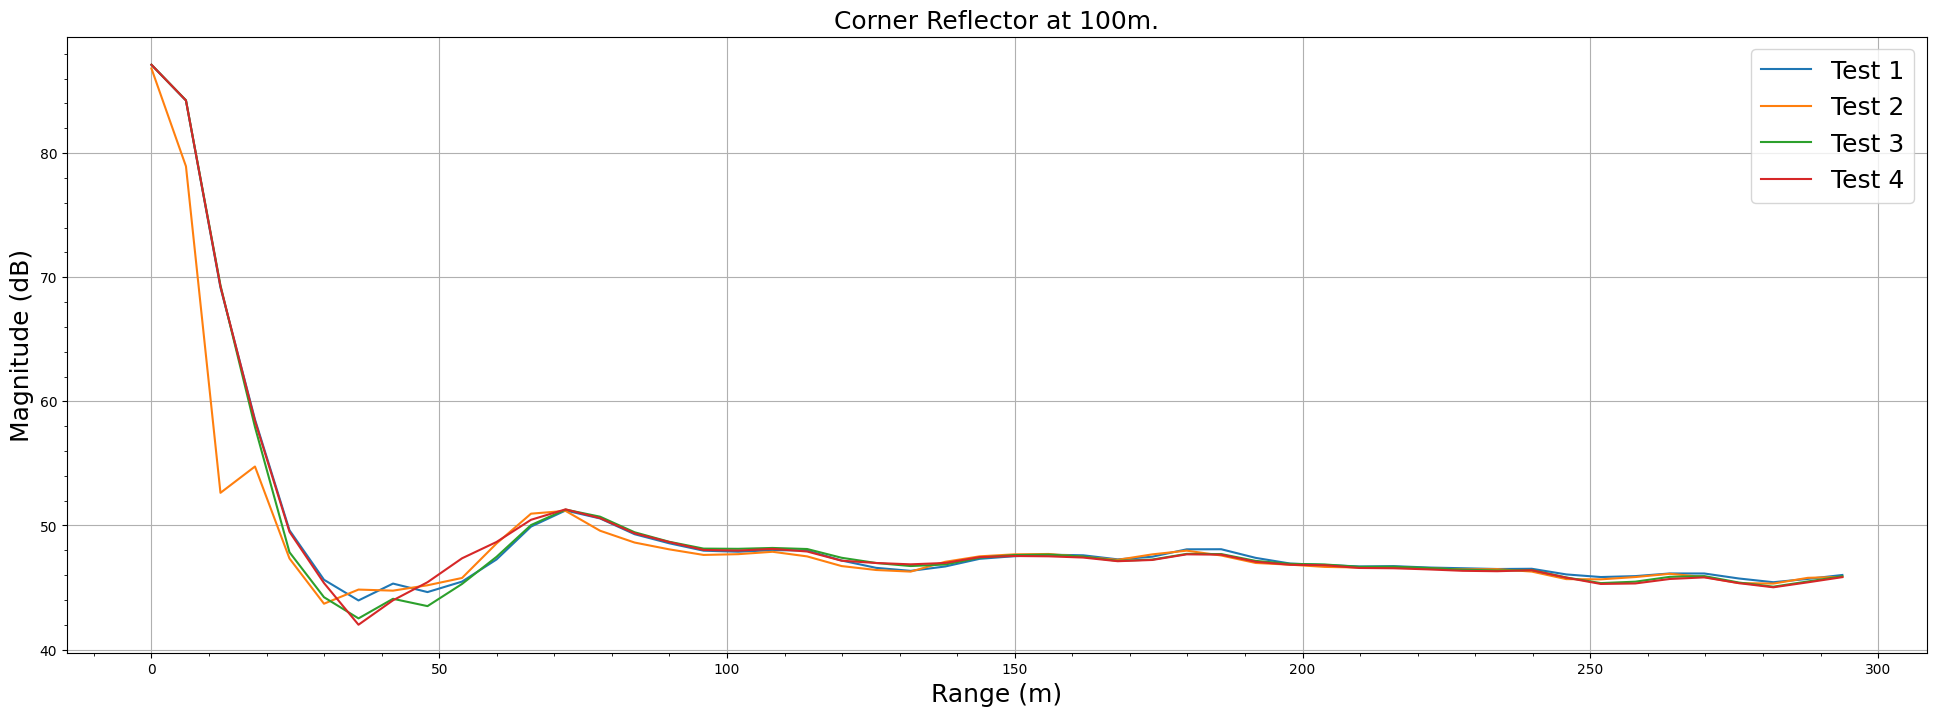

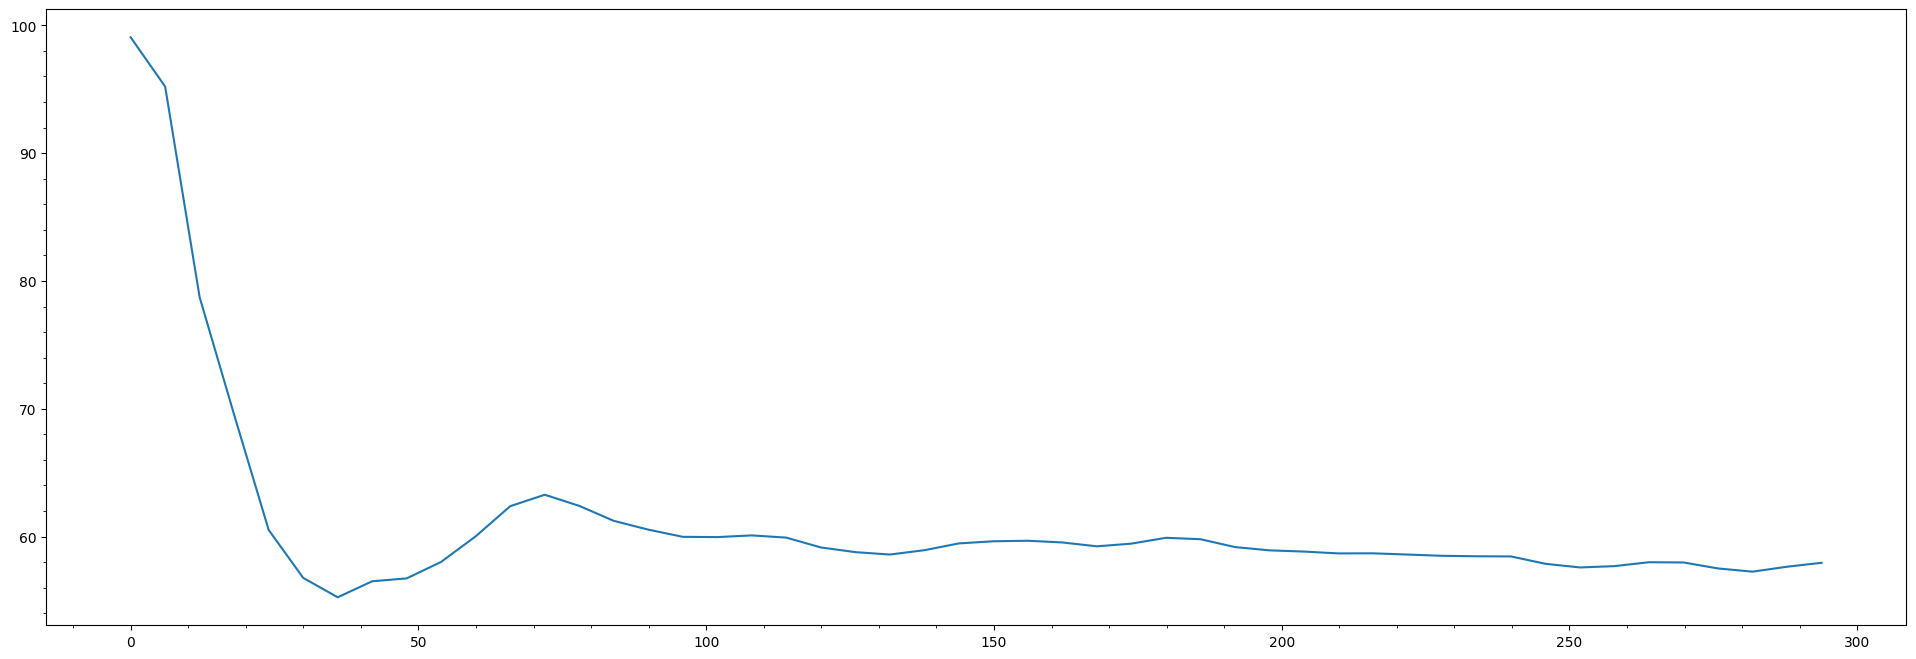

In [24]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]


def cpi(file_path, template_signal):
    data = read_iq_bin(file_path)
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 8, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(data, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
    # Extract pulses
    pulse_sum = np.zeros(50).astype(np.complex128)
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:50]
        if (len(xcorr_data_plot)==50):
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        else:
            break
    return pulse_sum

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]

d = 100
pulse_sum_0 = cpi(f"../outputs/outputs5/field_cr_{d}m_0.bin",template_signal)
pulse_sum_1 = cpi(f"../outputs/outputs5/field_cr_{d}m_1.bin",template_signal)
pulse_sum_2 = cpi(f"../outputs/outputs5/field_cr_{d}m_2.bin",template_signal)
pulse_sum_3 = cpi(f"../outputs/outputs5/field_cr_{d}m_3.bin",template_signal)

pulse_sum = pulse_sum_0 + pulse_sum_1 + pulse_sum_2 + pulse_sum_3

range_bins = np.arange(len(pulse_sum))

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_0)), label="Test 1")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_1)), label="Test 2")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_2)), label="Test 3")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_3)), label="Test 4")
plt.title(f"Corner Reflector at {d}m.", fontsize=18)
plt.minorticks_on()
#plt.xticks(range_bins)
plt.grid()
plt.legend(fontsize=18)
plt.xlabel("Range (m)", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.show()

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.show()


# Fieldfox

Frequency from 2500000000 to 3000000000


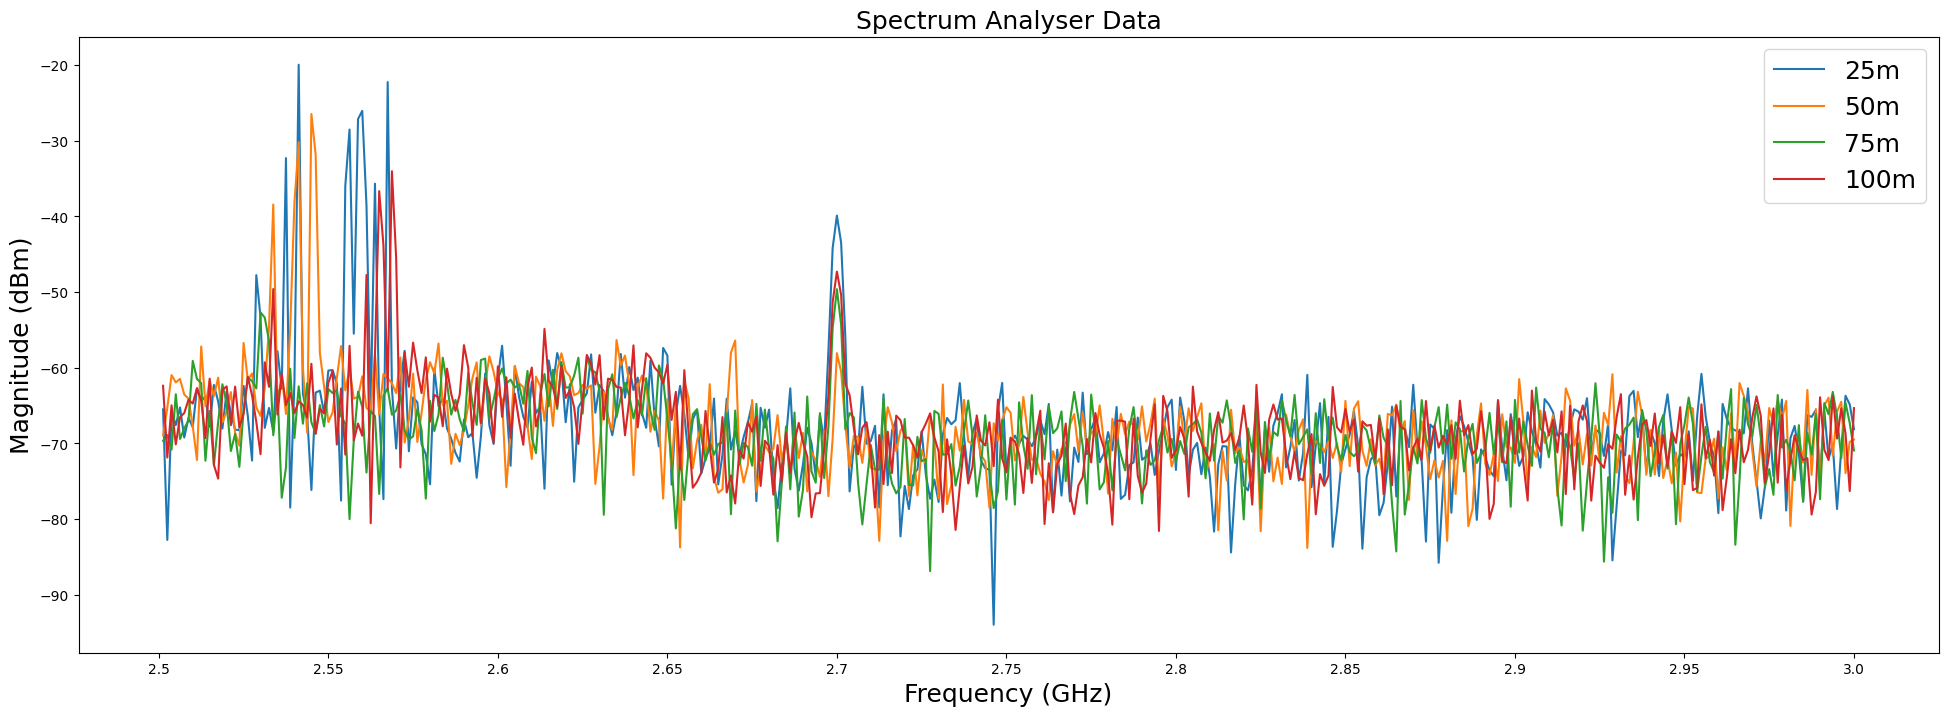

In [55]:
data_25 = pd.read_csv('../outputs/outputs5/25.csv')
data_50 = pd.read_csv('../outputs/outputs5/50.csv')
data_75 = pd.read_csv('../outputs/outputs5/75.csv')
data_100 = pd.read_csv('../outputs/outputs5/100.csv')

# Assuming the first column is 'X' and the second column is 'Y'
x_25 = data_25.iloc[:, 0]  # First column
y_25 = data_25.iloc[:, 1]  # Second column
x_50 = data_50.iloc[:, 0]  # First column
y_50 = data_50.iloc[:, 1]  # Second column
x_75 = data_75.iloc[:, 0]  # First column
y_75 = data_75.iloc[:, 1]  # Second column
x_100 = data_100.iloc[:, 0]  # First column
y_100 = data_100.iloc[:, 1]  # Second column

# Defining x tick interval
min_x = round(x_25.min(),-8)
max_x = x_25.max()
print(f"Frequency from {min_x} to {max_x}")
tick_interval = 50000000
ticks = np.arange(min_x, max_x + tick_interval, tick_interval)
tick_labels = ticks / 1e9

# Place marker where x is closest to 2.7 GHz (2.7 * 1e9 Hz)
#target_x = 2.7 * 1e9
#closest_index = (np.abs(x - target_x)).idxmin()  # Find the closest index
#closest_y_value = y[closest_index]

plt.figure(figsize=(24,8))
plt.title("Spectrum Analyser Data", fontsize=18)
plt.plot(x_25,y_25, label="25m")
plt.plot(x_50,y_50, label="50m")
plt.plot(x_75,y_100, label="75m")
plt.plot(x_100,y_75, label="100m")
#plt.plot(x[closest_index], y[closest_index], marker='o', markersize=10, color='red')
#plt.text(x[closest_index], y[closest_index]+1, f'2.7 GHz: {closest_y_value:.2f} dBm', 
#         fontsize=18, color='red', ha='left', va='bottom')
plt.xticks(ticks=ticks, labels=tick_labels)
plt.ylabel("Magnitude (dBm)", fontsize=18)
plt.xlabel("Frequency (GHz)", fontsize=18)
plt.legend(fontsize=18)
plt.show()

# Cell tower

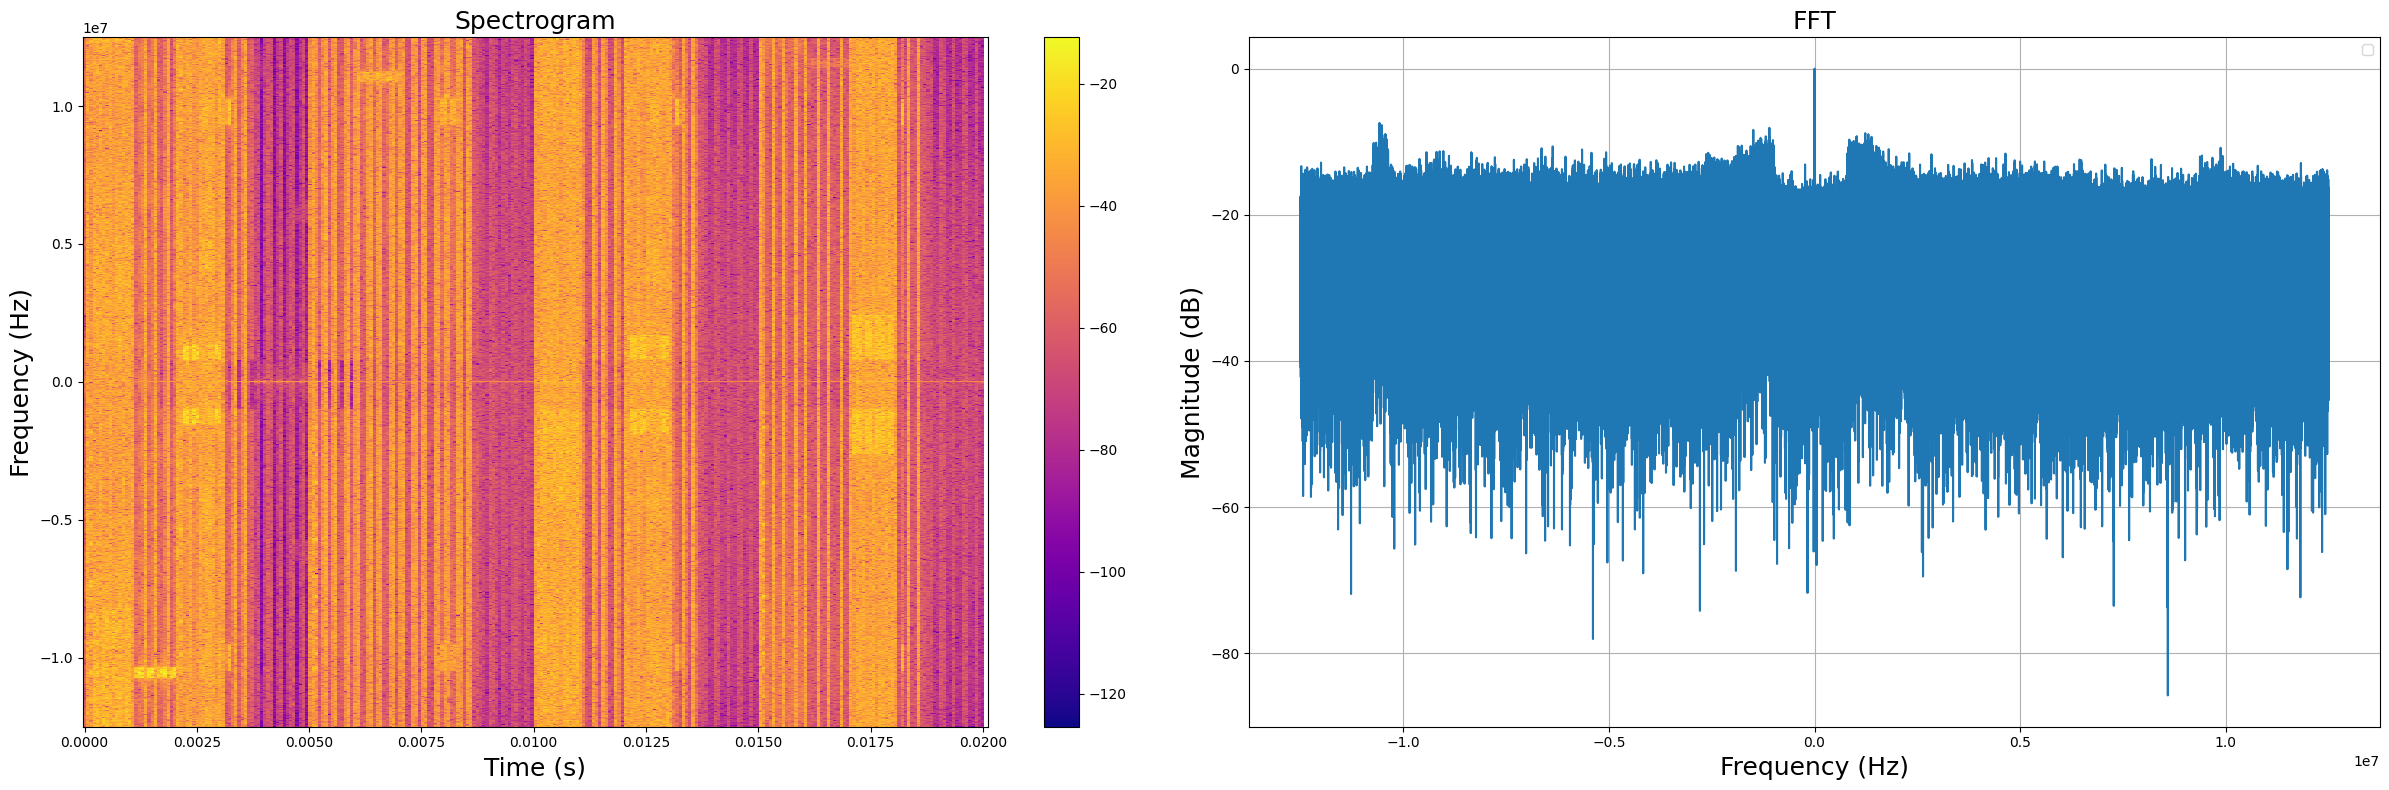

In [33]:
complex_data = read_iq_bin("../outputs/outputs5/rx_cell_0.bin")
fs = 25e6

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_ylabel('Frequency (Hz)', fontsize=18)
axs[0].set_title('Spectrogram', fontsize=18)

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude/np.max(magnitude))

axs[1].plot(fft_freq_axis, magnitude_db)
axs[1].set_title('FFT', fontsize=18)
axs[1].set_xlabel("Frequency (Hz)", fontsize=18)
axs[1].set_ylabel("Magnitude (dB)", fontsize=18)
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()



# Just Rx

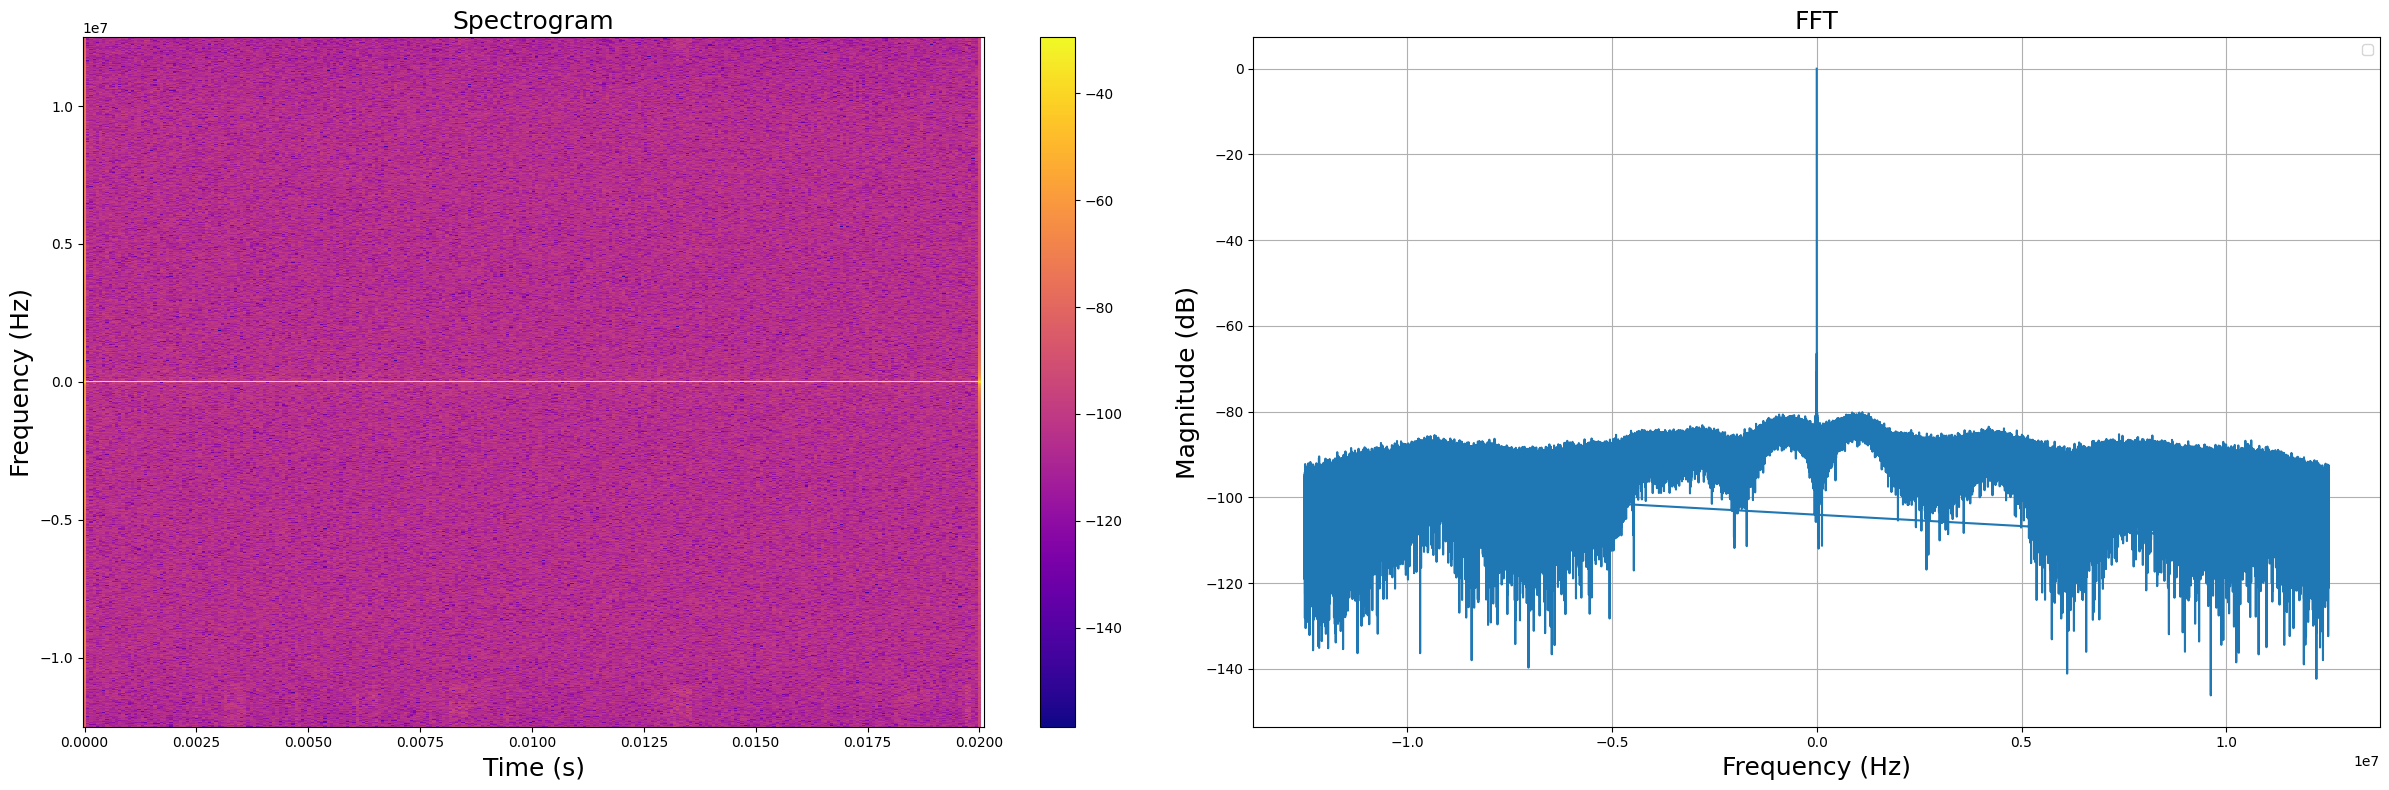

In [34]:
complex_data = read_iq_bin("../outputs/outputs5/field_rx_0.bin")
fs = 25e6

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_ylabel('Frequency (Hz)', fontsize=18)
axs[0].set_title('Spectrogram', fontsize=18)

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude/np.max(magnitude))

axs[1].plot(fft_freq_axis, magnitude_db)
axs[1].set_title('FFT', fontsize=18)
axs[1].set_xlabel("Frequency (Hz)", fontsize=18)
axs[1].set_ylabel("Magnitude (dB)", fontsize=18)
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()



# Lab tests

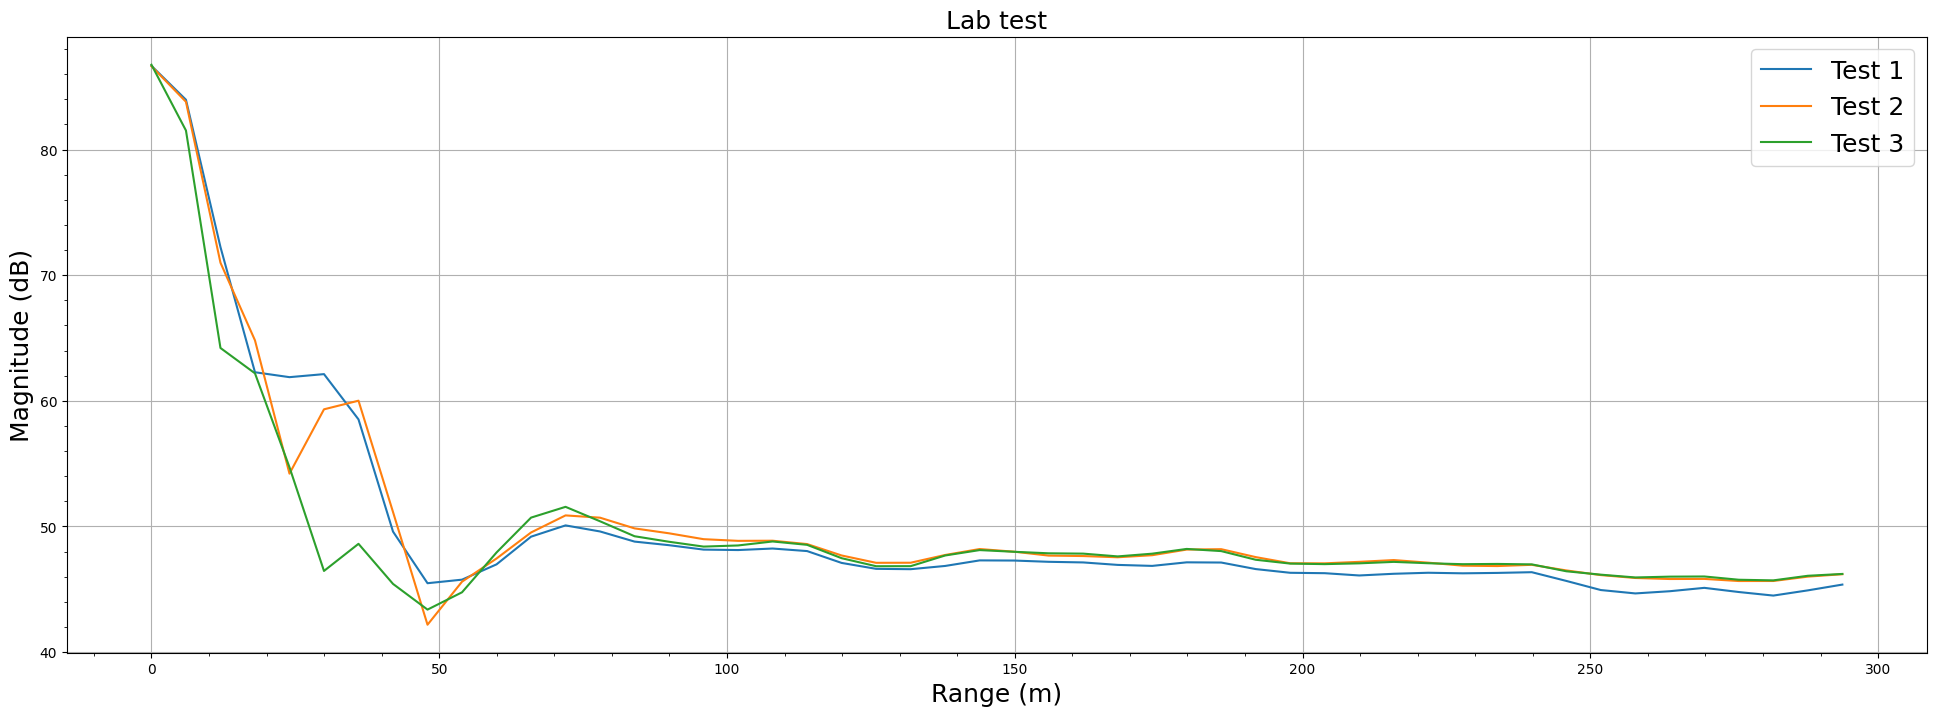

In [35]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]


def cpi(file_path, template_signal):
    data = read_iq_bin(file_path)
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 8, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(data, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
    # Extract pulses
    pulse_sum = np.zeros(50).astype(np.complex128)
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:50]
        if (len(xcorr_data_plot)==50):
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        else:
            break
    return pulse_sum

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]

pulse_sum_0 = cpi(f"../outputs/outputs4/lab_cr_0.bin",template_signal)
pulse_sum_1 = cpi(f"../outputs/outputs4/lab_cr_1.bin",template_signal)
pulse_sum_2 = cpi(f"../outputs/outputs4/lab_cr_2.bin",template_signal)

range_bins = np.arange(len(pulse_sum))

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_0)), label="Test 1")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_1)), label="Test 2")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_2)), label="Test 3")
plt.title("Lab test", fontsize=18)
plt.minorticks_on()
#plt.xticks(range_bins)
plt.grid()
plt.legend(fontsize=18)
plt.xlabel("Range (m)", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.show()
